In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import h5py
import json

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Convolution2D
from keras.optimizers import Adam, SGD
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


# Load Dataset

In [2]:
data_path='./data/udacity/'

dataset=pd.read_csv(data_path+'driving_log.csv', skiprows=1,skipinitialspace=True,
              names=['center','left','right','steering','throttle','brake','speed'])


## Dataset is heavily biased towards steering angle of 0

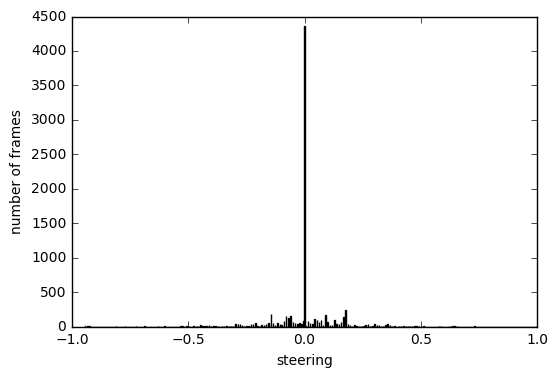

In [101]:
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
ax.hist(dataset.steering,bins=1000)
ax.set_xlabel('steering')
ax.set_ylabel('number of frames')
plt.show()

## Crop the top and bottom of images

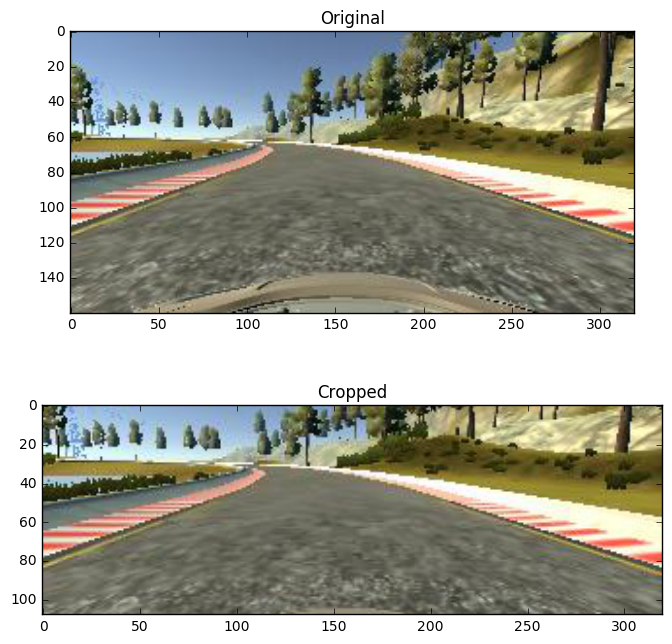

In [5]:
# Display image
frame_idx=5900
steering_angle=dataset.steering[frame_idx]
fpath=dataset.center[frame_idx]
img=cv2.imread(data_path+fpath)

fig=plt.figure(figsize=(8,8))
ax1=fig.add_subplot(211)
ax1.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
ax1.set_title('Original')

# Remove top and bottom pixels
cropped_img=img[32:-20,:,:]
ax2=fig.add_subplot(212)
ax2.imshow(cv2.cvtColor(cropped_img,cv2.COLOR_BGR2RGB))
ax2.set_title('Cropped')
plt.show()




## Data Augmentation : Translation

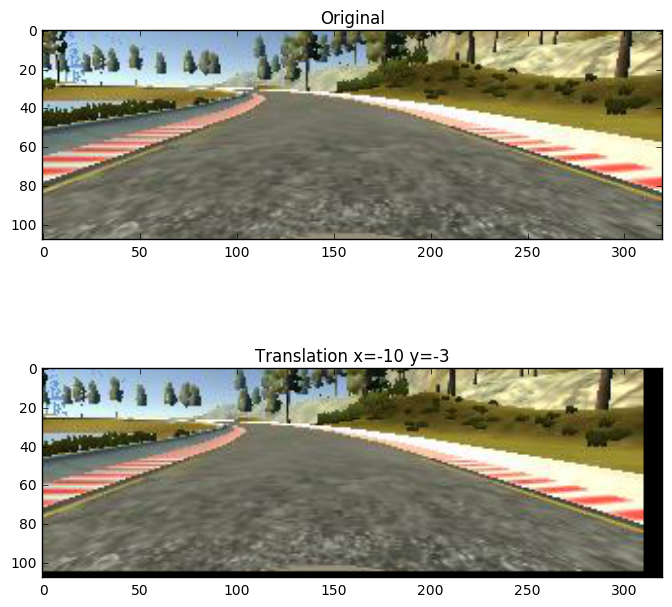

In [6]:
fig=plt.figure(figsize=(8,8))
ax1=fig.add_subplot(211)
ax1.imshow(cv2.cvtColor(cropped_img,cv2.COLOR_BGR2RGB))
ax1.set_title('Original')

# Translation
x_trans_range= int(0.1*cropped_img.shape[1])
x_trans = np.random.randint(low=-x_trans_range, high=x_trans_range)

y_trans_range= int(0.1*cropped_img.shape[0])
y_trans = np.random.randint(low=-y_trans_range, high=y_trans_range)
trans_matrix = np.float32([[1, 0, x_trans], [0, 1, y_trans]])
trans_img=cv2.warpAffine(cropped_img, trans_matrix, (cropped_img.shape[1], cropped_img.shape[0]))


ax2=fig.add_subplot(212)
ax2.imshow(cv2.cvtColor(trans_img,cv2.COLOR_BGR2RGB))
ax2.set_title('Translation x=%d y=%d'%(x_trans, y_trans))
plt.show()


## Data augmentation : Flipping images

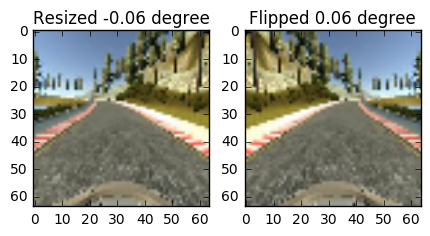

In [7]:
# resize to 64 x 64
resized_img=cv2.resize(img,(64,64))

fig=plt.figure(figsize=(5,5))
ax1=fig.add_subplot(121)
ax1.imshow(cv2.cvtColor(resized_img,cv2.COLOR_BGR2RGB))
ax1.set_title('Resized %.2f degree'%(steering_angle))


# flip image
flipped=cv2.flip(resized_img,1)
ax2=fig.add_subplot(122)
ax2.imshow(cv2.cvtColor(flipped,cv2.COLOR_BGR2RGB))
ax2.set_title('Flipped %.2f degree'%(-1*steering_angle))
plt.show()

## Data Augmentation : Varying Brightness

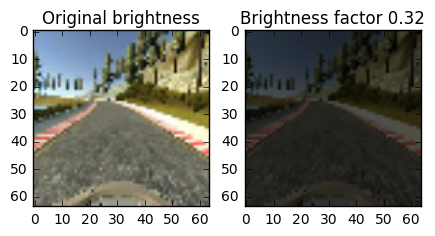

In [8]:
original_img=cv2.cvtColor(resized_img,cv2.COLOR_BGR2HSV)
brightness_img=original_img.copy()
brightness_factor=np.random.uniform(low=0.2, high=1.0)
brightness_img[:,:,2]=brightness_img[:,:,2]*brightness_factor


fig=plt.figure(figsize=(5,5))
ax1=fig.add_subplot(121)
ax1.imshow(cv2.cvtColor(original_img,cv2.COLOR_HSV2RGB))
ax1.set_title('Original brightness')

ax2=fig.add_subplot(122)
ax2.imshow(cv2.cvtColor(brightness_img,cv2.COLOR_HSV2RGB))
ax2.set_title('Brightness factor %.2f'%(brightness_factor))
plt.show()


# Pipeline to process frame and augmentation

In [3]:
def process_img(line_data):
    # select randomly center, left or right camera

    camera=np.random.randint(3)
    if camera==0:
        fpath=line_data['left'].strip()
        angle_shift=0.25
    if camera==1:
        fpath=line_data['center'].strip()
        angle_shift=0.0
    if camera==2:
        fpath=line_data['right'].strip()
        angle_shift=-0.25
    
    # read image    
    img=cv2.imread(data_path+fpath)

    # add steering angle shift
    angle = line_data['steering']+angle_shift
    
    # Translation
    x_trans_range= int(0.2*img.shape[1])
    x_trans = np.random.randint(low=-x_trans_range, high=x_trans_range)
    angle_trans = x_trans/x_trans_range*0.2
    angle=angle+angle_trans
    
    y_trans_range= int(0.1*img.shape[0])
    y_trans = np.random.randint(low=-y_trans_range, high=y_trans_range)
    trans_matrix = np.float32([[1, 0, x_trans], [0, 1, y_trans]])
    img=cv2.warpAffine(img, trans_matrix, (img.shape[1], img.shape[0]))

    # Convert Color space and augment brightness
    img=cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
    brightness_factor=np.random.uniform(low=0.2, high=1.0)
    img[:,:,2]=img[:,:,2]*brightness_factor
    
    # Resize image
    img=img[32:-20,:,:]
    img=cv2.resize(img,(64,64))
    
    # flip image
    if np.random.randint(2)==0:
        img=cv2.flip(img,1)
        angle=-1*angle

    # normalise
    img=np.float32(img/255-0.5)
    
    return img, angle


In [5]:
def image_generator_(bias_threshold, batch_size=200):

    gen_img=np.empty((batch_size, 64,64,3),np.float32)
    gen_steering=np.empty((batch_size),np.float32)
    while 1:
        for i in range(batch_size):
            idx=np.random.randint(len(dataset))
            exceed_threshold=False
            while exceed_threshold==False:
                x,y=process_img(dataset.iloc[idx])
            
                if ((abs(y)<0.1) and (np.random.uniform()>bias_threshold)) or (abs(y)>=0.1):
                    exceed_threshold=True
                    
            gen_img[i]=x
            gen_steering[i]=y
        yield gen_img, gen_steering


# CNN Architecture

In [4]:
#Compile and train the model.
model=Sequential()

# Convolutional 1
model.add(Convolution2D(nb_filter=24,nb_row=5, nb_col=5, subsample=(2,2),
                        border_mode='valid', activation='relu', input_shape=(64,64,3)))
model.add(Convolution2D(nb_filter=36,nb_row=5, nb_col=5, subsample=(2,2),
                        border_mode='valid' ,activation='relu'))
model.add(Convolution2D(nb_filter=48,nb_row=5, nb_col=5, subsample=(2,2),
                        border_mode='valid' ,activation='relu'))
model.add(Convolution2D(nb_filter=64,nb_row=3, nb_col=3, subsample=(1,1),
                        border_mode='valid' ,activation='relu'))

model.add(Dropout(0.5))
# Dense 
model.add(Flatten())

model.add(Dense(500, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.5))

# Output
model.add(Dense(1))
    
# load pre-trained weights
#model.load_weights('model.h5')

# compile
optimizer=Adam(lr=5e-3, decay=0.75)

model.compile(loss='mean_squared_error', 
              optimizer=optimizer, 
              metrics=['mean_squared_error'])

# Save model
model_json=model.to_json()
with open("model.json","w") as json_file:
    json.dump(model_json, json_file)
   

# Training

In [ ]:
total_nb_epoch=5

for epoch in range(total_nb_epoch):
    bias_threshold=1/(epoch+1)
    image_generator=image_generator_(bias_threshold, batch_size=1000)
    model.fit_generator(image_generator, samples_per_epoch=20000, nb_epoch=1, verbose=1)
    
# Save weight
#model.save_weights('model.h5')